In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022

本文件仿真有泵浦光补偿的情况，假设有未知参数，进行逆向研究

@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1, torch"""
import deepxde as dde
import numpy as np
import pandas as pd
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma
from scipy.special import lambertw

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)

## 定义模型变量
q_lambda = dde.Variable(0.1)

## 单位统一至cm，定义各个参数
D = 0.585
Rsd = 17.5573
#Rwall = 2.654 # 泡壁碰撞的参数是不是错啦
Rwall = 2.56401
rpump = 0.75
q = 5
#qlambda_real = 0.5
rcell = 1.5

#Rrel = Rsd + (q+q_lambda)*Rwall
I = 25*1e-3*1e4 # kg*(cm)^2/s^3
T = 170
k1 = 10**(-20)*10**8 # kg*cm^4/s^2
k2 = 10**(-17)*10**4 # cm^2
k3 = 1 # cm^-3
sigm = 2.34601*10**(-13) # cm^2

n = k3*(1/(T+273.15))*10**(21.866+4.402-4453/(T+273.15))




Using backend: pytorch



In [2]:
def gen_traindata():
    #data = np.load("../dataset/Lorenz.npz")
    filename_3D = './COMSOL_data/Q_unknown.csv'
    #df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
    df_3D = pd.read_csv(filename_3D, header=9, names=['x', 'y', 'z', 'Pz'])
    point_num = 5000
    axis_3D_x = np.asarray(df_3D['x'])[:point_num]
    axis_3D_y = np.asarray(df_3D['y'])[:point_num]
    axis_3D_z = np.asarray(df_3D['z'])[:point_num]
    axis_3D_Pz = np.asarray(df_3D['Pz'])[:point_num]
    axis_3D_axis = np.stack((axis_3D_x, axis_3D_y, axis_3D_z), axis=1)
    
    return axis_3D_axis, axis_3D_Pz.reshape(-1, 1)



300
176.27631760593877


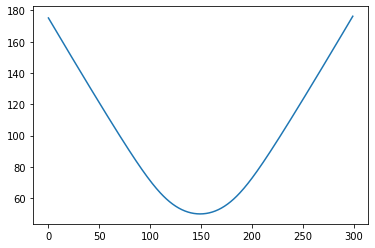

In [3]:
## 读取COMSOL生成数据
filename_Rop = './COMSOL_data/inverse_Rop0.csv'
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df_Rop = pd.read_csv(filename_Rop, header=14, names=['Rop'])
Rop_raw = df_Rop['Rop']

plt.plot(Rop_raw)
print(len(Rop_raw))
from scipy.interpolate import interp1d
z_axis = np.linspace(-1.5, 1.5, 300)
Func_Rop = interp1d(z_axis, Rop_raw)
print(Func_Rop(1.5))

In [4]:
def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
#     x_arr = x.eval(session=sess)
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj
    
    Rop_z = Func_Rop(z)    
    Rop = Rop_z * np.exp(-2*(x**2+y**2)/rpump**2)
    Rop = torch.from_numpy(Rop).cuda()
    #Rop = Rop0
    
    return -D*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/(q+q_lambda)+Rwall)*y_in - Rop/(q+q_lambda)

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    #Rop = Rop0 * np.exp(-2*(x**2+y**2)/rpump**2)

    Rop_z = Func_Rop(z)    
    Rop = Rop_z * np.exp(-2*(x**2+y**2)/rpump**2)
    
    
    second_term = np.sqrt(1/2*np.abs(Rop*D))
    second_term = torch.from_numpy(second_term).cuda()
    Rop = torch.from_numpy(Rop).cuda()
    # tranfer back to torch.tensor
    #Rop = torch.from_numpy(Rop).cuda()
#     x = torch.from_numpy(x).cuda()
#     y = torch.from_numpy(y).cuda()
#     z = torch.from_numpy(z).cuda()
    x = x_in[:, 0:1]
    y = x_in[:, 1:2]
    z = x_in[:, 2:3]
    
    return (D/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*second_term)


In [ ]:
geom = dde.geometry.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC


## 添加变量参数约束

# Get the train data
observe_axis, ob_pz = gen_traindata()
print('Pz shape ', ob_pz.shape)
observe_points = dde.icbc.PointSetBC(observe_axis, ob_pz, component=0)


data = dde.data.PDE(geom, bloch_pde,\
                    [bc, observe_points],\
                    num_domain=25000, num_boundary=3000,\
                   anchors=observe_axis)

net = dde.nn.FNN([3] + [60] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4, external_trainable_variables=[q_lambda])
#losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
variable = dde.callbacks.VariableValue(
    [q_lambda], period=500, filename="variables.dat"
)
# losshistory, train_state = model.train(iterations=60000, callbacks=[variable])
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)
losshistory, train_state = model.train(epochs=30000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Pz shape  (5000, 1)


C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+25002=25002. 
  total_n_samples))
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+3002=3002. 
  total_n_samples))


Compiling model...
'compile' took 0.000165 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.02e+01, 8.84e-02, 5.21e-02]    [4.02e+01, 8.84e-02, 5.21e-02]    []  
1000      [4.76e-01, 1.04e+00, 6.99e-03]    [4.76e-01, 1.04e+00, 6.99e-03]    []  
2000      [1.55e-01, 1.11e+00, 8.21e-03]    [1.55e-01, 1.11e+00, 8.21e-03]    []  
3000      [1.44e-01, 9.88e-01, 7.25e-03]    [1.44e-01, 9.88e-01, 7.25e-03]    []  
4000      [1.65e-01, 7.94e-01, 5.59e-03]    [1.65e-01, 7.94e-01, 5.59e-03]    []  
5000      [1.18e-01, 3.67e-01, 2.78e-03]    [1.18e-01, 3.67e-01, 2.78e-03]    []  
6000      [8.51e-02, 1.27e-01, 1.27e-03]    [8.51e-02, 1.27e-01, 1.27e-03]    []  
7000      [2.86e-02, 1.28e-02, 2.84e-04]    [2.86e-02, 1.28e-02, 2.84e-04]    []  
8000      [1.28e-02, 3.36e-03, 9.70e-05]    [1.28e-02, 3.36e-03, 9.70e-05]    []  
9000      [7.24e-03, 1.96e-03, 5.25e-05]    [7.24e-03, 1.96e-03, 5.25e-05]    []  
10000     [4.80

In [ ]:
## 读取dat文件，并绘图

q_datFile = pd.read_csv("variables.dat", header=None, usecols=[0])

#q_data = np.asarray(q_datFile)
#plt.plot(q_data)
q_data = []
for i in q_datFile[0]:
    q_data.append(float(i.split('[')[1].split(']')[0]))
    
    
plt.plot(q_data)    

In [ ]:
'''
读取Ref文件，COMSOL仿真结果
'''

# 读取z-axis实验结果
filename = './COMSOL_data/dual_light_zaxis.csv'
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df = pd.read_csv(filename, header=9, names=['Pz'])
## (x, y, z) u1, 20796*4

# x = np.asarray(df['x'])
# y = np.asarray(df['y'])
# z = np.asarray(df['z'])
ZAxis_COMSOL = np.asarray(df['Pz'])
#Pz
#len(Pz) cm, 注意单位换算，统一m
z_sequence = np.linspace(-1.5, 1.5, 300)

plt.plot(z_sequence, ZAxis_COMSOL)

# 读取3D仿真结果文件
filename_3D = './COMSOL_data/3D_dual_light.csv'
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df_3D = pd.read_csv(filename_3D, header=9, names=['x', 'y', 'z', 'Pz'])
axis_3D_x = np.asarray(df_3D['x'])
axis_3D_y = np.asarray(df_3D['y'])
axis_3D_z = np.asarray(df_3D['z'])
axis_3D_Pz = np.asarray(df_3D['Pz'])
axis_3D_axis = np.stack((axis_3D_x, axis_3D_y, axis_3D_z), axis=1)
axis_3D_axis.shape